In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd 
import dask.dataframe as dd  #http://pythondata.com/dask-large-csv-python/
import os
from tqdm import tqdm
import numpy as np

TRAIN_PATH = 'train.csv'
#TRAIN_PATH = 'drive/My Drive/Colab Notebooks/deep_learning/train.csv'

In [3]:
%%time
with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())

print (f'Exact number of rows: {n_rows}')


Exact number of rows: 55423857
CPU times: user 7.76 s, sys: 3.69 s, total: 11.4 s
Wall time: 11.6 s


## Functions

In [4]:
def clean(df):
    print('No of records b4 fare amount filter: ',len(df))
    df = df[df.fare_amount >= 0]
    print('No of records after fare amount filter ',  len(df))
    print('No of records b4 passenger count filter ',  len(df))
    df= df[df.passenger_count > 0]
    print('No of records after passenger count filter ',  len(df))
        # Remove inconsistent values
    print('No of records b4 same point filter ',  len(df))
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    print('No of records after same point filter ',  len(df))
    
def add_travel_vector_features(df): #coordinate fatures v1
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_distances_features(df):
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    df['latdiff']= abs(df['latdiff'])
    df['londiff']= abs(df['londiff'])
    return df

traintypes = {'fare_amount': 'float32',
     'pickup_datetime': 'str', 
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'passenger_count': 'uint8'}

cols = list(traintypes.keys())


#Based on the code of https://www.kaggle.com/akeshari/new-york-taxi-fare-prediction


## Read data

### Read with dask


In [ ]:
%%time

df_train = dd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes,parse_dates=["pickup_datetime"])
 # parse_dates keyword to parse the timestamp column to be a datetime. This will make things more efficient in the future. Notice that the dtype of the timestamp column has changed from object to datetime64[ns].
#ddf.info()
df_train.head()


CPU times: user 44.3 s, sys: 175 ms, total: 44.5 s
Wall time: 44.5 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


### Read with pandas


In [5]:
%%time
#Read sample data 
df_train =  pd.read_csv(TRAIN_PATH, nrows = 1000000,usecols=cols, dtype=traintypes, parse_dates=["pickup_datetime"])
df_train.head()

CPU times: user 1min 12s, sys: 99.4 ms, total: 1min 12s
Wall time: 1min 12s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [6]:
print('minimum and maximum longitude', min(df_train.pickup_longitude.min(), df_train.dropoff_longitude.min()),',',
max(df_train.pickup_longitude.max(), df_train.dropoff_longitude.max()))

print('minimum and maximum latitude ',min(df_train.pickup_latitude.min(), df_train.dropoff_latitude.min()),',',
max(df_train.pickup_latitude.max(), df_train.dropoff_latitude.max()))


minimum and maximum longitude -3383.2966 , 2522.2712
minimum and maximum latitude  -3116.2854 , 2621.6284


### Call functions

No of records b4 fare amount filter:  1000000
No of records after fare amount filter  999962
No of records b4 passenger count filter  999962
No of records after passenger count filter  996397
No of records b4 same point filter  996397
No of records after same point filter  966933


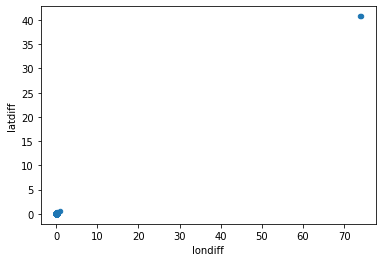

In [7]:
clean(df_train)

add_coordinate_features(df_train)
df_train=add_time_features(df_train)
df_train=add_distances_features(df_train)

df_train.head(5)
df_train.iloc[:2000].plot.scatter('londiff', 'latdiff')

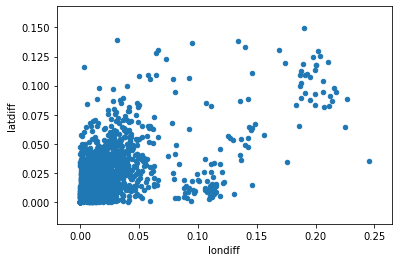

In [8]:
df_train = df_train[(df_train.londiff < 5.0) & (df_train.latdiff < 0.2)]
df_train.iloc[:2000].plot.scatter('londiff', 'latdiff')

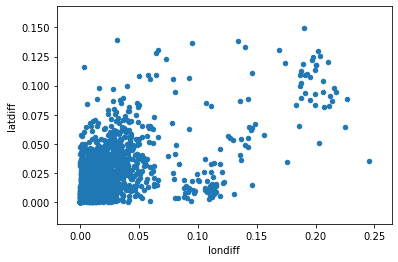

In [10]:
df_train = df_train[(df_train.pickup_latitude >= 40) & (df_train.pickup_latitude <= 42)]
df_train = df_train[(df_train.pickup_longitude >= -75) & (df_train.pickup_longitude <= -73)]
df_train = df_train[(df_train.dropoff_latitude >= 40) & (df_train.dropoff_latitude <= 42)]
df_train = df_train[(df_train.dropoff_longitude >= -75) & (df_train.dropoff_longitude <= -73)]
df_train.iloc[:2000].plot.scatter('londiff', 'latdiff')

In [11]:

# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']
df_train_clean = df_train.drop(dropped_columns, axis=1)

# peek data
df_train_clean.head(5)


,fare_amount,passenger_count,latdiff,londiff,year,month,day,hour,weekday,night,...,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,1,0.009041,0.002701,2009,6,15,17,0,1,...,0.009436,0.011742,0.169220,0.166664,0.139248,0.127506,0.362007,0.355667,0.074371,0.086113
1,16.9,1,0.070702,0.036774,2010,1,5,16,1,1,...,0.079693,0.107475,0.012524,0.094952,0.300964,0.334892,0.180264,0.287739,0.204739,0.121273
2,5.7,2,0.010708,0.008507,2011,8,18,0,3,0,...,0.013676,0.019215,0.070751,0.051537,0.317619,0.315418,0.263538,0.244324,0.121464,0.140678
3,7.7,1,0.024948,0.004440,2012,4,21,4,5,0,...,0.025340,0.029388,0.038231,0.058739,0.293888,0.323277,0.231018,0.251526,0.153984,0.133476
4,5.3,1,0.015755,0.011436,2010,3,9,7,1,0,...,0.019468,0.027191,0.092133,0.119324,0.309719,0.314037,0.284920,0.312111,0.100082,0.100418


## Train and test

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val= train_test_split(df_train_clean, test_size=0.30, random_state=1)


# Get labels
y_train = x_train['fare_amount'].values
y_val = x_val['fare_amount'].values

x_train = x_train.drop(['fare_amount'], axis=1)
x_val = x_val.drop(['fare_amount'], axis=1)

In [13]:
import sklearn.preprocessing as preprocessing

# Scale data
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)


## GradientBoostingRegressor

In [14]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators =500, max_depth=5, min_samples_split=2,learning_rate=0.01, loss='ls')

In [15]:
clf.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
print("R2 for GradientBoostingRegressor ",clf.score(x_val,y_val)*100)


R2 for GradientBoostingRegressor  83.20700181690242


In [26]:
from sklearn.metrics import mean_squared_error

mse1 = mean_squared_error(y_val, clf.predict(x_val))
print("RMSE for GradientBoostingRegressor ",np.sqrt(mse1))

RMSE for GradientBoostingRegressor  3.9123086848491937


## Random Forest Regressor

In [18]:
# Model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
#rfr = RandomForestRegressor(n_estimators=30, max_features=20, max_depth=25, min_samples_split=2, min_samples_leaf=3, random_state=0)
rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_val)

In [19]:
# Scores
#Check later for preprocessing https://www.kaggle.com/aiswaryaramachandran/eda-and-feature-engineering
#https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78

n = 60
results = pd.DataFrame({'real_fare': y_val, 'pred_fare': rfr_pred})
results['error'] = rfr_pred - y_val
#results['error'].mean()*100
results.head(n).round(2).T

print("score_train for Random Forest is ",rfr.score(x_train,y_train)*100)
print("score_val for Random Forest is ",rfr.score(x_val,y_val)*100 )

score_train for Random Forest is  97.70316433143375
score_val for Random Forest is  83.95370609729181


In [20]:
#Metrics

#Returns the coefficient of determination R^2 of the prediction.
#https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-two-predictive-modelling-f80461a8072efrom sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

rf_rmse=np.sqrt(mean_squared_error(y_val,rfr_pred))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.82433884203385


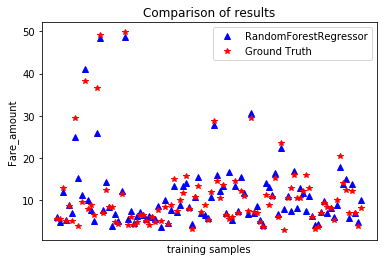

In [21]:
#Plotting predictions and labels

import matplotlib.pyplot as plt

plt.figure()
plt.plot(rfr_pred[:100] , 'b^', label='RandomForestRegressor')
plt.plot(y_val[:100] , 'r*', label='Ground Truth')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Fare_amount')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of results')
plt.show()

## XGBoost

In [22]:
import xgboost as xgb

In [23]:
#https://www.kaggle.com/yashah19/nyc-taxi-fare-prediction
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_val)
params = {'max_depth':10,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.1
         }
num_rounds = 50

xb = xgb.train(params, dtrain, num_rounds)
y_pred_xgb = xb.predict(dtest)

n = 60
results2 = pd.DataFrame({'real_fare': y_val, 'pred_fare': y_pred_xgb})
results2['error'] = y_pred_xgb - y_val
results2.head(n).round(2).T
    

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
real_fare,5.50,5.50,12.90,5.00,8.70,5.00,29.500000,4.00,9.70,38.330002,...,12.00,28.900000,14.50,10.50,13.7,6.50,5.500000,6.00,14.50,6.90
pred_fare,5.93,4.46,12.09,5.47,9.21,6.64,25.110001,5.58,9.67,40.090000,...,10.03,27.700001,16.09,12.36,13.0,6.64,18.190001,6.02,13.04,6.37
error,0.43,-1.04,-0.81,0.47,0.51,1.64,-4.390000,1.58,-0.03,1.760000,...,-1.97,-1.200000,1.59,1.86,-0.7,0.14,12.690000,0.02,-1.46,-0.53


In [24]:
from sklearn.metrics import mean_squared_error, r2_score

rf_rmse2=np.sqrt(mean_squared_error(y_pred_xgb,y_val))
print("RMSE for Xgboost ",rf_rmse2)
rf_r2score=r2_score(y_val,y_pred_xgb)
print("r2_score for Xgboost ",rf_r2score*100)

RMSE for Xgboost  3.7603118
r2_score for Xgboost  84.4864999401012


## Keras Neural Net


In [42]:
#https://www.kaggle.com/ottpeterr/what-s-a-ride-cost-2-of-2-neural-net
#https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
#https://datascienceplus.com/keras-regression-based-neural-networks/

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras import metrics
from keras import backend as K



model = Sequential()
model.add(Dense(32, kernel_initializer="normal", input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5));
model.add(Dense(32, kernel_initializer="normal", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="normal", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, kernel_initializer="normal", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="normal", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer="normal", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='nadam',  #'nadam', #
              metrics=[metrics.mae])


In [43]:
num_epochs = 25
batch_size = 2**12
history = model.fit(x_train, y_train, 
                    validation_data = (x_val, y_val),
                    shuffle=True, 
                    epochs=num_epochs, 
                    batch_size=batch_size)

Train on 685076 samples, validate on 293605 samples
Epoch 1/25
685076/685076 [==============================] - 8s 11us/step - loss: 98.4036 - mean_absolute_error: 6.9415 - val_loss: 97.0697 - val_mean_absolute_error: 5.2813
Epoch 2/25
685076/685076 [==============================] - 6s 9us/step - loss: 34.6220 - mean_absolute_error: 3.3268 - val_loss: 80.7917 - val_mean_absolute_error: 4.9242
Epoch 3/25
685076/685076 [==============================] - 6s 9us/step - loss: 30.0657 - mean_absolute_error: 3.0210 - val_loss: 50.3934 - val_mean_absolute_error: 3.6670
Epoch 4/25
685076/685076 [==============================] - 6s 9us/step - loss: 28.6693 - mean_absolute_error: 2.9170 - val_loss: 31.6919 - val_mean_absolute_error: 2.9554
Epoch 5/25
685076/685076 [==============================] - 6s 9us/step - loss: 27.8801 - mean_absolute_error: 2.8641 - val_loss: 29.5171 - val_mean_absolute_error: 3.1606
Epoch 6/25
685076/685076 [==============================] - 6s 9us/step - loss: 27.3600

Text(0.5, 0, 'epoch')

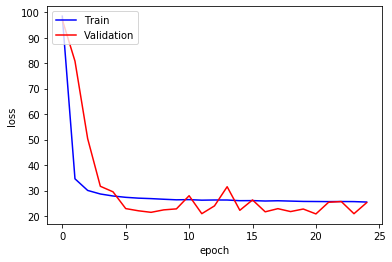

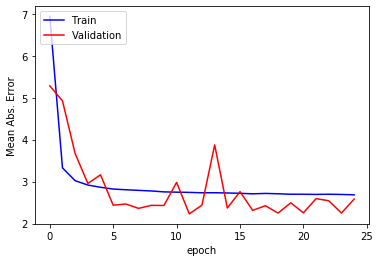

In [44]:
import matplotlib.pyplot as plt
                                                   
plt.figure()         
plt.plot(history.history['loss'], color="blue")
plt.plot(history.history['val_loss'], color="red")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")

plt.figure()
plt.plot(history.history['mean_absolute_error'], color="blue")
plt.plot(history.history['val_mean_absolute_error'], color="red")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylabel("Mean Abs. Error")
plt.xlabel("epoch")

In [45]:
print("RMSE for Neural Network -Keras",np.sqrt(history.history['val_loss'][9]))

RMSE for Neural Network -Keras 4.777925594559156


## Pytorch 

In [ ]:
#https://www.kaggle.com/dienhoa/nyc-taxi-fare-neural-network-with-pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
model = nn.Sequential(nn.Linear(20, 50), 
                      nn.ReLU(),
                      nn.Dropout(0.25),  
                      nn.Linear(50, 30),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(30, 20),
                      nn.ReLU(),
                      nn.Linear(20, 1))



In [ ]:
model = nn.Sequential(nn.Linear(20, 10),
                     nn.Linear(10, 5),
                      nn.Linear(5, 1))

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [257]:
#X = np.stack((train_df.abs_diff_latitude.values,train_df.abs_diff_longitude.values)).T
X  =x_train
X = torch.from_numpy(X)
X = X.type(torch.FloatTensor)
np.shape(x_train), np.shape(X)

((6990, 20), torch.Size([6990, 20]))

In [ ]:
y= torch.from_numpy(y_train.T)
y = y.type(torch.FloatTensor)


In [260]:
for epoch in range(600):
      # Zero the gradients
    optimizer.zero_grad()
    # Forward Propagation
    y_pred = model(X)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())

    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([6990])) that is different to the input size (torch.Size([6990, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  0  loss:  102.23892211914062
epoch:  1  loss:  102.10613250732422
epoch:  2  loss:  102.28717803955078
epoch:  3  loss:  102.20805358886719
epoch:  4  loss:  102.16754150390625
epoch:  5  loss:  101.94801330566406
epoch:  6  loss:  102.10901641845703
epoch:  7  loss:  101.98424530029297
epoch:  8  loss:  101.80917358398438
epoch:  9  loss:  102.01914978027344
epoch:  10  loss:  101.91820526123047
epoch:  11  loss:  101.79932403564453
epoch:  12  loss:  101.75992584228516
epoch:  13  loss:  101.83650207519531
epoch:  14  loss:  101.58812713623047
epoch:  15  loss:  101.76824188232422
epoch:  16  loss:  101.74055480957031
epoch:  17  loss:  101.67932891845703
epoch:  18  loss:  101.7022933959961
epoch:  19  loss:  101.5423583984375
epoch:  20  loss:  101.63890838623047
epoch:  21  loss:  101.60906219482422
epoch:  22  loss:  101.43679809570312
epoch:  23  loss:  101.58455657958984
epoch:  24  loss:  101.51986694335938
epoch:  25  loss:  101.423828125
epoch:  26  loss:  101.476486

In [ ]:
X_test = x_val
X_test = torch.from_numpy(X_test)
X_test = X_test.type(torch.FloatTensor)

In [ ]:
y_test_p = model(X_test)
y_test_p = y_test_p.detach().numpy()
y_test_p = y_test_p.reshape(-1)

In [264]:
n = 60
results4 = pd.DataFrame({'real_fare': y_test_p, 'pred_fare': y_val})
results4['error'] = y_test_p - y_val
results4.head(n).round(2).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
real_fare,11.2,11.29,11.39,11.21,10.78,11.57,11.23,11.29,11.34,11.18,11.49,11.18,11.36,11.18,11.36,11.360000,11.3,11.5,11.28,11.33,11.43,10.93,11.4,11.37,11.320000,11.79,11.82,11.23,11.76,11.04,10.99,11.59,11.56,10.83,11.21,11.27,11.59,11.280000,11.06,11.32,11.28,11.28,11.13,11.68,11.81,11.56,11.66,11.32,11.55,11.49,11.58,11.24,11.23,11.6,11.56,10.99,10.87,10.8,11.07,11.29
pred_fare,9.5,6.50,6.50,10.50,7.30,12.10,8.50,10.50,3.00,14.70,7.70,8.50,8.90,12.00,3.30,85.500000,3.7,10.5,11.70,4.10,6.50,13.70,10.5,10.10,36.099998,20.50,13.00,9.50,15.70,6.50,9.50,8.00,11.30,9.00,5.70,6.10,5.00,19.299999,6.50,7.30,5.30,9.30,6.50,7.50,7.00,4.50,13.50,7.50,12.10,5.70,5.00,7.00,7.50,5.5,8.50,6.10,12.50,9.5,13.30,8.50
error,1.7,4.79,4.89,0.71,3.48,-0.53,2.73,0.79,8.34,-3.52,3.79,2.68,2.46,-0.82,8.06,-74.139999,7.6,1.0,-0.42,7.23,4.93,-2.77,0.9,1.27,-24.780001,-8.71,-1.18,1.73,-3.94,4.54,1.49,3.59,0.26,1.83,5.51,5.17,6.59,-8.020000,4.56,4.02,5.98,1.98,4.63,4.18,4.81,7.06,-1.84,3.82,-0.55,5.79,6.58,4.24,3.73,6.1,3.06,4.89,-1.63,1.3,-2.23,2.79


In [266]:
def rmse(y_pred, targ):
    pct_var = (targ - y_pred)
    return np.sqrt((pct_var**2).mean())
  
rmse4 =rmse(y_test_p,y_val)
print("RMSE for Neural Network -pytorch",rmse4)

RMSE for Neural Network -pytorch 8.813696
